# Black box attack on a Linear SVM: Decision boundary poisoning

If regularly browse machine learning websites, you may have seen the image of a self-driving car baffled by a circle of salt drawn on the ground. This 'hack' on the car's sensing devices shows that there is still some work to do to make sure that machine learning algorithms are robust to malicious (or accidental) data manipulation. 

Sarah Jamie Lewis' post on [adversarial machine learning](https://mascherari.press/introduction-to-adversarial-machine-learning/) is a great introduction and bibliography on the topic of machine learning. One of the papers the article links to is ['Can Machine Learning be Secure?'](https://people.eecs.berkeley.edu/~tygar/papers/Machine_Learning_Security/asiaccs06.pdf) by Barreno et al. 

Barreno et al describe various ways to detect attacks and among them talk about examining points near the decision boundary. A large cluster of points around the boundary might indicate that an exploratory attack is taking place.

I wanted to take this idea of points at the decision bounary and explore how one could force a Linear Support Vector Machine classifier trained on the famous Iris dataset to misclassify a rogue point.



## Attack description

This attack with premises that make it largely unrealistic. For example, the attacker in this case has full knowledge of the dataset, can visualise the decision boundary and can force the classifier to retrain at will. This most likely will never happen in the real world. 
This is a blackbox attack, meaning we assume that the attacker does not know anything about the internals of the Linear SVM classifier and its training process. 

1. Begin with a classifier trained on the Iris dataset to distinguish between the Iris setosa and Iris versicolor species
2. The attacking class will be Iris versicolor. We will inject a rogue point into the Iris setosa dataset and then poison the training data until this rogue point is classified as Iris versicolor. 


### Prepare the training data

In [13]:
import sklearn
import pandas as pd
import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#prepare the class labels. Iris setosa will be labelled as -1, Iris versicolor as 1
X = df.iloc[0:100, 4].values
y= np.where(X=="Iris-setosa", -1, 1)

In [5]:
#prepare the training data
data = df.iloc[0:100, [0,2]].values

### Visualise training data

As we can see from the image below, the data points (whose locations are based on the petal length and sepal length of the two species of Iris ) are linearly separable - so we should be able to learn a good decision boundary with the Linear SVM. 

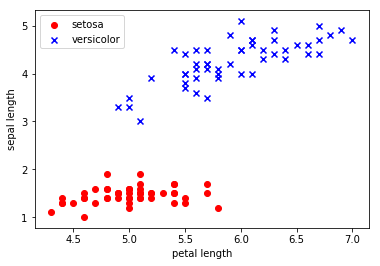

In [9]:
plt.scatter(data[:50, 0], data[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(data[50:100, 0], data[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('petal length')
plt.ylabel('sepal length')
plt.legend(loc='upper left')
plt.show()

### Attack tools

To monitor the progress of the attack, we will define a helper function below. The function plots the decision boundary learned from the classifier as well as the data. I implemented the function based on the exposition in _Python: Deeper Insights into Machine Learning_ by John Hearty, David Julian and Sebastian Raschka. 

In [10]:
def plot_decision_regions(data, y, classifier, resolution=0.02):
    """
    A function that plots decision regions based on "Implementing a perceptron algorithm in Python by Raschka et al.
    """
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #meshgrid
    x1min, x1max = data[:,0].min()-1, data[:, 0].max()+1
    x2min, x2max = data[:,1].min()-1, data[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=data[y==cl,0], y=data[y==cl, 1], 
                   alpha=0.8, c=cmap(idx), 
                   marker=markers[idx], label=cl)
    plt.scatter(x=[6.0], y=[1.8], 
               alpha=0.8, marker='v', c='cyan')

### Linear SVM classification

We will be using the Linear SVM implementation from scikit-learn.

In [11]:
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(data, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [45]:
clf.predict([[5.0, 1.0]])

array([-1])

## Plotting the decision surface before the attack
This is the situation before we begin poisoning the decision boundary. I have added the rogue point in light blue/cyan into the red class at (6.0, 1.8). The aim will be to move the decision boundary so that this point will be misclassified as blue class.

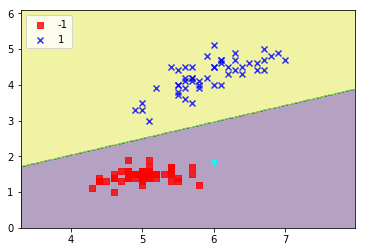

In [16]:
plot_decision_regions(data, y, clf)
plt.legend(loc='upper left')
plt.show()

In [34]:
def add_attack_point(data, y, attack_points, attack_class=1):
    """
    Add a new attack point to the dataset
    
    Returns:
    --------
    
    New dataset including attack point
    
    New class label vector including label for attacking class (1 in this case)
    """
    return np.concatenate((data, attack_points)), np.concatenate((y, np.array(len(attack_points)*[attack_class])))

In [35]:
def retrain_and_plot(clf, new_data, new_y):
    """
    Retrain the classifier with new data and plot the result
    """
    clf.fit(new_data, new_y)
    plot_decision_regions(new_data, new_y, clf)
    plt.legend(loc='upper left')
    plt.show()

### Attack 1 : Add single data point and see what happens

In [36]:
new_data, new_labels = add_attack_point(data, y, [[6.0, 2.0]])

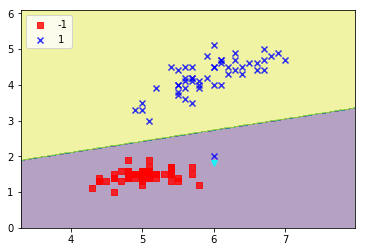

In [37]:
retrain_and_plot(clf, new_data, new_labels)

One of the instances from blue class now falls within the decision boundary of the red class, but this has not caused a remarkable shift in the position of the decision boundary. Let's continue adding more points close to the rogue point we wish to re-classify as blue. 

### Attack 2: More poisoned datapoints

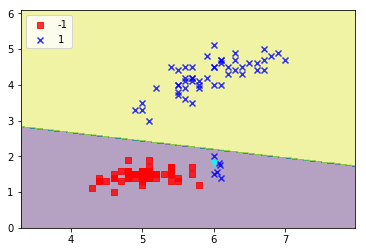

In [39]:
x1_new = [6.0, 6.1, 6.05, 6.08, 6.09]
x2_new = [1.5, 1.4, 1.55, 1.8, 1.75]
new_vals = map(list, zip(x1_new, x2_new))
new_data_2, new_labels_2 = add_attack_point(new_data, new_labels, new_vals)
retrain_and_plot(clf, new_data_2, new_labels_2)

The decision boundary is clearly shifting - close to the mass of new blue attack points. 

### Attack 3

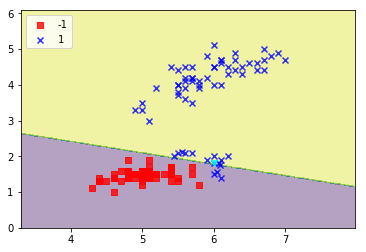

In [46]:
x1_new = [5.5, 5.6, 5.559, 5.7, 5.45, 6.0, 6.1, 6.2, 5.9]
x2_new = [2.1, 2.105, 2.110, 2.089, 2.0, 1.8, 1.9, 2.0, 1.9]
new_vals = map(list, zip(x1_new, x2_new))
new_data_3, new_labels_3 = add_attack_point(new_data_2, new_labels_2, new_vals)
retrain_and_plot(clf, new_data_3, new_labels_3)

The rogue point is now classified as class 1. 

In [48]:
rogue_point = [[6.0, 1.8]]
clf.predict(rogue_point)

array([1])

### Summary
This was a brief and very incomplete experiment with changing the decision boundaries of Linear SVM classifiers by adding poisoned training data close to the decision boundary. One of the major shortcomings of this exposition is that the points were added in a largely random manner around the rogue point without any sort of attack system. In the next few essays on this subject I hope to present a white box approach to poisoning SVMs ( attacks where attacker has intricate knowledge of how support vector machines work ) as well as developing systematic data poisoning approaches. 